This tutorial shows how to train a model recognizing the words. Like the MNIST dataset in the image classification task. The task gives you the basic understanding of techniques involved in the speech recognition. After you finished the tutorial, you would have a model for recognizing the basic words, like `down`, `go`, `right`, etc.

In [ ]:
import logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s-%(levelname)s: %(message)s")

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython import display

import tensorflow as tf
logging.info("Tensorflow Version: {}".format(tf.__version__))
logging.info("GPU is{} available.".format("" if tf.config.list_physical_devices("GPU") else " not"))

from tensorflow.python.client import device_lib
logging.info(device_lib.list_local_devices())

2021-03-11 08:04:36,820-INFO: Tensorflow Version: 2.4.1
2021-03-11 08:04:36,820-INFO: GPU is available.
2021-03-11 08:04:36,833-INFO: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15344943766731470999
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10813335093755441605
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
SEED=100
tf.random.set_seed(SEED)
np.random.seed(SEED)

# The Speech Commands Dataset

You'll download and use a portion of the [speech commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The origin dataset consists of over 105,000 wav audio files of people saying thirty different words. This data was collected by Google and released under a CC BY licenses.

You are going to use the small portion of the dataset named `mini_speech_commands.zip`.

In [ ]:
dataDir = pathlib.Path('data/mini_speech_commands')
if not dataDir.exists():
  logging.warning("Start to download the mini dataset.")
  tf.keras.utils.get_file('mini_speech_commands.zip',
                          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
                          extract=True,
                          cache_dir='.',
                          cache_subdir="data")

Let's take a look at the dataset downloaded.

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(dataDir)))
commands = commands[commands != "README.md"]
commands

array(['right', 'down', 'left', 'go', 'no', 'stop', 'yes', 'up'],
      dtype='<U9')

Extract and fulfill the paths of audio files into a list and shuffle it.

In [ ]:
filenames = tf.io.gfile.glob(str(dataDir) + "/*/*")
filenames = tf.random.shuffle(filenames)
numSamples = len(filenames)

logging.info("There are {} audio files.".format(numSamples))
logging.info("Command {} has {} pieces of audio files.".format(
  commands[0], len(tf.io.gfile.listdir(str(dataDir) + "/" + commands[0]))
))
logging.info("The example tensor of filename: {}.".format(filenames[0]))

filenames[0]

2021-03-11 08:04:37,465-INFO: There are 8000 audio files.
2021-03-11 08:04:37,468-INFO: Command right has 1000 pieces of audio files.
2021-03-11 08:04:37,470-INFO: The example tensor of filename: b'data/mini_speech_commands/left/876c84d6_nohash_0.wav'.


<tf.Tensor: shape=(), dtype=string, numpy=b'data/mini_speech_commands/left/876c84d6_nohash_0.wav'>

Split the dataset into 80:10:10 ratio for training, validation, and testing.

In [ ]:
trainFiles = filenames[:6400]
valFiles = filenames[6400:7200]
testFiles = filenames[-800:]

logging.info("Train size: {}, Validation Size: {}, Test Size: {}".format(
  len(trainFiles), len(valFiles), len(testFiles)
))

2021-03-11 08:04:37,488-INFO: Train size: 6400, Validation Size: 800, Test Size: 800


# Reading the audio files and their labels

The audio file in wav format is uncompressed and can be determined by the sample rate (Hz) and the sample size (bit). In this dataset, each audio file is with 16KHz of sample rate and with 16-bit of sample size.

For training a model, each audio file initially be read as a binary file, which you'll  have to convert into a numerical tensor. To load an audio file, you can use the `tf.audio.decode_wav` API, which returns the WAV-encoded audio as a Tensor and its sample rate. A wav file contains time series data with a set number of samples per second. Each samplerepresents the amplititude of the audio signal at the specific time.

More details, the amplititude in each sample ranges from -32768 to +32767 (2^16) and will be normalized to [-1.0, 1.0] after `tf.audio.decode_wav`.

In [ ]:
def decodeAudio(audioInBinary):
  audio, sampleRate = tf.audio.decode_wav(audioInBinary)
  return tf.squeeze(audio, axis=-1), sampleRate

In [ ]:
def getLabel(filePath):
  parts = tf.strings.split(filePath, os.path.sep)
  # left, ...
  return parts[-2]

In [ ]:
def getWAVandLabel(filePath):
  """Package the pair of both the audio content and the audio label."""
  label = getLabel(filePath=filePath)
  audioInBinary = tf.io.read_file(filename=filePath)
  content, _ = decodeAudio(audioInBinary=audioInBinary)
  return content, label

In [ ]:
getWAVandLabel(filenames[0])

(<tf.Tensor: shape=(16000,), dtype=float32, numpy=
 array([-0.00537109, -0.00567627, -0.0057373 , ...,  0.00552368,
         0.00604248,  0.00665283], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'left'>)

Next you are going to build a data generation pipeline.

In [ ]:
trainDs = tf.data.Dataset.from_tensor_slices(trainFiles)
trainDs = trainDs.map(getWAVandLabel, num_parallel_calls=tf.data.AUTOTUNE)

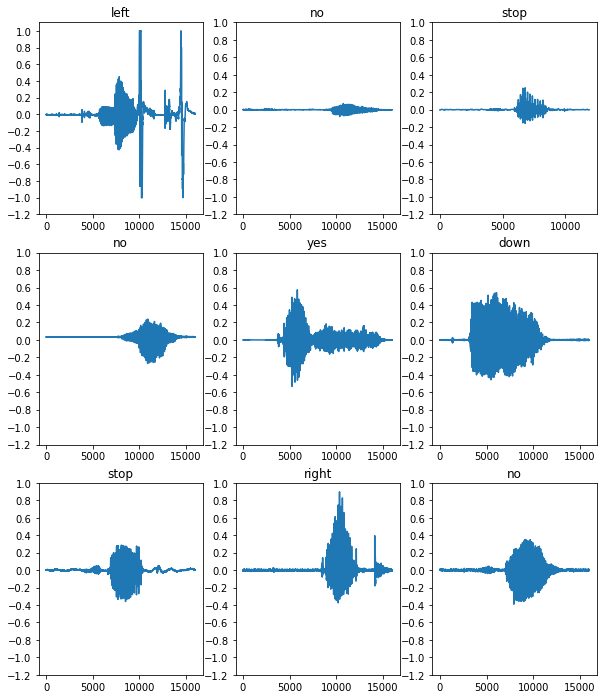

In [ ]:
rows = 3
cols = 3
nums = rows * cols

fig, axs = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(trainDs.take(nums)):
  row = i // cols
  col = i % cols
  ax = axs[row][col]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(label.numpy().decode('utf-8'))

plt.show()

# Spectrogram

You will convert the waveform into a spectrogram, which shows changes over time and can be represented as a 2D image. This can be done by applying the `short-term Fourier transform` (`STFT`) to convert the audio waveform into the time-frequency domain.

A Fourier Transform (`tf.signal.fft`) converts a signal to its component frequencies, but losses all time information. The `STFT` (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information. It also returns a 2D tensor, in this case, you can build a convolutional network for those 2D tensor.

Further, `STFT` produces an array of complex numbers representing magnitude and phase (- or +). However, you'll only need the magnitude for training a model, which can be simply addressed by applying `tf.abs` on the output of `tf.signal.stft`. 

In `STFT`, choosing `frame_length` and `frame_step` parameters to generate spectrogram image is also important. Finaly, you want the waveforms to have the same length, so when you convert it to the spectrogram image, they will have similar dimensions. This can be done by padding zeros at the end of the audio clips that are shorted than one second.

In [ ]:
def getSpectrogram(waveform=None):
  """Transform the waveform into a fixed dimension spectrogram image."""
  # zero padding for those files with less than the bit rate, e.g. 16000
  zeroPadding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # concatenate audio with padding to make all audio clips the same length
  waveform = tf.cast(waveform, tf.float32)
  equalLength = tf.concat([waveform, zeroPadding], axis=0)
  spectrogram = tf.signal.stft(
    equalLength, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)
  return spectrogram

In [ ]:
for waveform, label in trainDs.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = getSpectrogram(waveform=waveform)

logging.info("Label: {}".format(label))
logging.info("Waveform shape: {}".format(waveform.shape))

# 124 = int(16000 / 128) - 1
# 129 is the default value and can be set by (fft_length / 2) + 1
logging.info("Spectrogram shape: {}".format(spectrogram.shape))

2021-03-11 08:04:38,519-INFO: Label: left
2021-03-11 08:04:38,519-INFO: Waveform shape: (16000,)
2021-03-11 08:04:38,521-INFO: Spectrogram shape: (124, 129)


In [ ]:
display.display(display.Audio(waveform, rate=16000))

In [ ]:
def plotSpectrogram(spectrogram, ax):
  # transpose the spectrogram to make the time is represented in X-axis (columns)
  logSpec = np.log(spectrogram.T)
  height = logSpec.shape[0]
  time = np.arange(16000, step=height+1)
  component = range(height)
  ax.pcolormesh(time, component, logSpec)

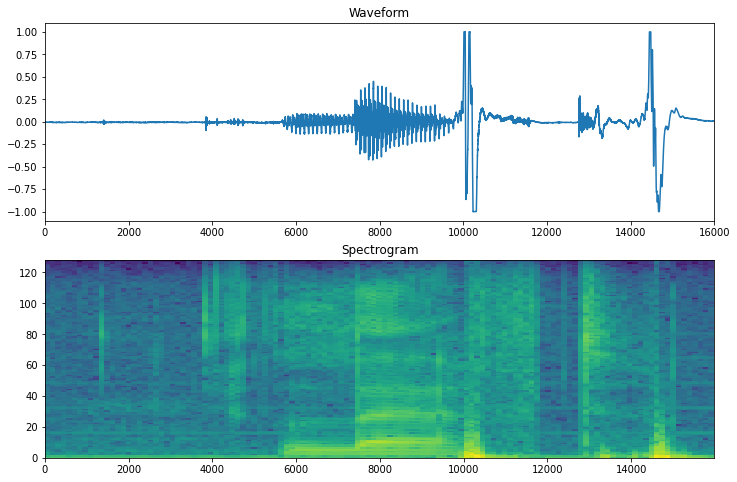

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timeseries = np.arange(waveform.shape[0])
axes[0].plot(timeseries, waveform.numpy())
axes[0].set_title("Waveform")
axes[0].set_xlim([0, waveform.shape[0]])
plotSpectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def getSpectrogramAndLabelID(waveform, label):
  """Build the function for building the pipeline of datasets."""
  spectrogram = getSpectrogram(waveform)
  spectrogram = tf.expand_dims(spectrogram, axis=-1) # for convolutional network
  labelID = tf.argmax(commands == label)
  return spectrogram, labelID

spectrogramDs = trainDs.map(getSpectrogramAndLabelID, num_parallel_calls=tf.data.AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


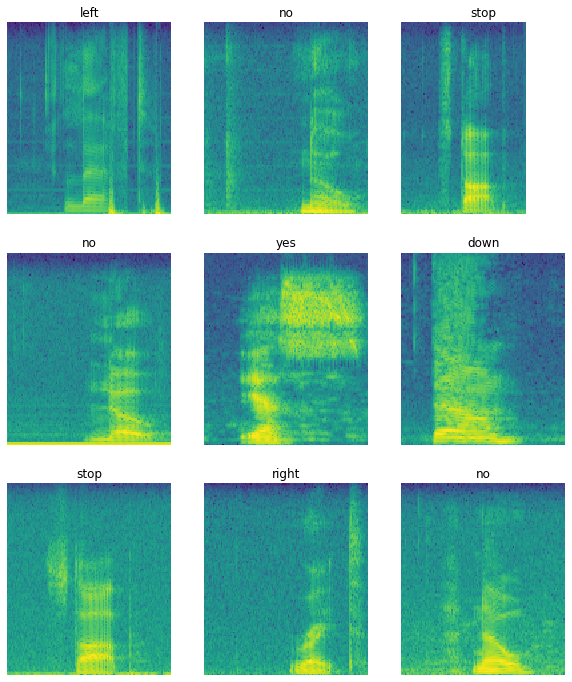

In [ ]:
nrow = 3
ncol = 3
nums = nrow * ncol

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 12))
for i, (spectrogram, labelID) in enumerate(spectrogramDs.take(nums)):
  label = commands[labelID.numpy()]
  spectrogram = tf.squeeze(spectrogram, -1).numpy()

  rowIdx = i // ncol
  colIdx = i % ncol
  plotSpectrogram(spectrogram, axes[rowIdx][colIdx])
  axes[rowIdx][colIdx].set_title(label)
  axes[rowIdx][colIdx].axis("off")

plt.show()

# Build and Train the Model

Before training the model, you first need to build the dataset pipeline.

In [ ]:
def datasetPipeline(files):
  retDs = tf.data.Dataset.from_tensor_slices(files)
  retDs = retDs.map(getWAVandLabel, num_parallel_calls=tf.data.AUTOTUNE)
  retDs = retDs.map(
    getSpectrogramAndLabelID, num_parallel_calls=tf.data.AUTOTUNE)
  return retDs

batchSize = 64

# add `cache()` and `prefetch()` to reduce read latency while training the model
trainDs = datasetPipeline(trainFiles).batch(batchSize).cache().prefetch(tf.data.AUTOTUNE)
valDs = datasetPipeline(valFiles).batch(batchSize).cache().prefetch(tf.data.AUTOTUNE)
testDs = datasetPipeline(testFiles)

While building the mode, two additional layers are added.

* a layer for normalization on the training dataset with mean and standard deviation
* a layer for resizing on the spectrogram to speedup the training

In [ ]:
for spectrogram, _ in spectrogramDs.take(1):
  inputShape = spectrogram.shape
logging.info("The input shape of the spectrogram: {}".format(inputShape))
numLabels = len(commands)

# here we first normalize the training dataset with the mean and the standard deviation
normalLayer = tf.keras.layers.experimental.preprocessing.Normalization()
normalLayer.adapt(spectrogramDs.map(lambda x, _: x))

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=inputShape),
  tf.keras.layers.experimental.preprocessing.Resizing(64, 64),       # [None, 64, 64, 1]
  normalLayer,
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),  # [None, 64, 64, 16]
  tf.keras.layers.Conv2D(20, 5, padding='same', activation='relu'),  # [None, 64, 64, 20]
  tf.keras.layers.MaxPooling2D(),                                    # [None, 32, 32, 20] 
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),  # [None, 32, 32, 32]
  tf.keras.layers.Conv2D(40, 5, padding='same', activation='relu'),  # [None, 32, 32, 40]
  tf.keras.layers.MaxPooling2D(),                                    # [None, 16, 16, 40]
  tf.keras.layers.Flatten(),                                         # [None, 16*16*40]
  tf.keras.layers.Dense(128, activation='relu'),                     # [None, 128]
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(numLabels)                                   # [None, numLabels]
])

model.summary()

2021-03-11 08:57:43,432-INFO: The input shape of the spectrogram: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 64, 64, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 20)        8020      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        5

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [ ]:
epochs = 20
history = model.fit(
  trainDs, 
  validation_data=valDs, 
  epochs=epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)]
)

Epoch 1/20
100/100 [==============================] - 45s 144ms/step - loss: 1.9423 - accuracy: 0.2543 - val_loss: 1.2097 - val_accuracy: 0.6150
Epoch 2/20
100/100 [==============================] - 1s 11ms/step - loss: 1.1685 - accuracy: 0.5808 - val_loss: 0.6687 - val_accuracy: 0.7887
Epoch 3/20
100/100 [==============================] - 1s 11ms/step - loss: 0.7736 - accuracy: 0.7368 - val_loss: 0.4872 - val_accuracy: 0.8325
Epoch 4/20
100/100 [==============================] - 1s 11ms/step - loss: 0.5934 - accuracy: 0.7968 - val_loss: 0.4247 - val_accuracy: 0.8512
Epoch 5/20
100/100 [==============================] - 1s 11ms/step - loss: 0.4789 - accuracy: 0.8369 - val_loss: 0.3720 - val_accuracy: 0.8712
Epoch 6/20
100/100 [==============================] - 1s 11ms/step - loss: 0.3978 - accuracy: 0.8652 - val_loss: 0.3657 - val_accuracy: 0.8850
Epoch 7/20
100/100 [==============================] - 1s 11ms/step - loss: 0.3632 - accuracy: 0.8746 - val_loss: 0.2999 - val_accuracy: 0.89

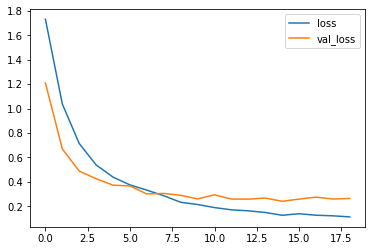

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluate the Model

In [ ]:
testAudios = []
testLabels = []

for audio, label in testDs:
  testAudios.append(audio.numpy())
  testLabels.append(label.numpy())

testAudios = np.array(testAudios)
testLabels = np.array(testLabels)

preds = model.predict(testAudios)
predLabels = tf.argmax(preds, axis=-1)
accuracy = (predLabels.numpy() == testLabels).astype('int').sum() / len(testLabels)
logging.info("Accuracy: {:.2%}".format(accuracy))

2021-03-11 09:37:13,830-INFO: Accuracy: 92.12%


## Display a confusion matrix

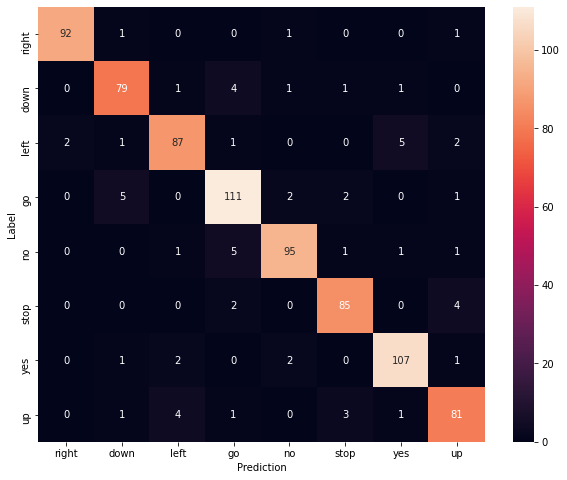

In [ ]:
confusionMatrix = tf.math.confusion_matrix(testLabels, predLabels.numpy())
plt.figure(figsize=(10, 8))
sns.heatmap(confusionMatrix, 
            xticklabels=commands, 
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Run inference on the example audio file

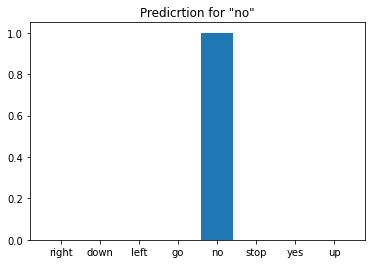

In [ ]:
sampleFile = [str(dataDir/'no/01bb6a2a_nohash_0.wav')]
sampleDs = datasetPipeline(sampleFile)

for spectrogram, label in sampleDs.batch(1):
  pred = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(pred[0]))
  plt.title(f'Predicrtion for "{commands[label[0]]}"')
  plt.show()